# SMARTER 50K

This is an attempt to test tstree with different 50K data. A single example of
50 samples is described in `notebooks/03-smarter_database.ipynb`. Here we want
to select different breeds from 50K and test how the tstree will results

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tskitetude import get_data_dir
from tskitetude.smarterapi import SheepEndpoint

Collect all sheep samples from 50K:

In [2]:
sheep_api = SheepEndpoint()

data = sheep_api.get_samples(chip_name="IlluminaOvineSNP50")
page = page = data["page"]
sheep = pd.DataFrame(data["items"])

while data["next"] is not None:
    data = sheep_api.get_samples(page=page+1, _type="background")
    df_page = pd.DataFrame(data["items"])
    page = data["page"]
    sheep = pd.concat([sheep, df_page], ignore_index=True)

sheep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5892 entries, 0 to 5891
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _id          5892 non-null   object 
 1   breed        5892 non-null   object 
 2   breed_code   5892 non-null   object 
 3   chip_name    5892 non-null   object 
 4   country      5892 non-null   object 
 5   dataset_id   5892 non-null   object 
 6   locations    4849 non-null   object 
 7   metadata     4878 non-null   object 
 8   original_id  5892 non-null   object 
 9   phenotype    577 non-null    object 
 10  smarter_id   5892 non-null   object 
 11  species      5892 non-null   object 
 12  type         5892 non-null   object 
 13  father_id    58 non-null     object 
 14  mother_id    58 non-null     object 
 15  sex          501 non-null    float64
 16  alias        156 non-null    object 
dtypes: float64(1), object(16)
memory usage: 782.7+ KB


Count how many samples I have by breed:

In [3]:
sheep_count = sheep.groupby('breed_code').size().reset_index(name='count')
sheep_count

,breed_code,count
0,AAW,24
1,ADP,21
2,AFS,37
3,AIM,88
4,ALP,24
...,...,...
204,WIL,23
205,WMH,24
206,XIS,24
207,ZEL,24


Plot count distribution:

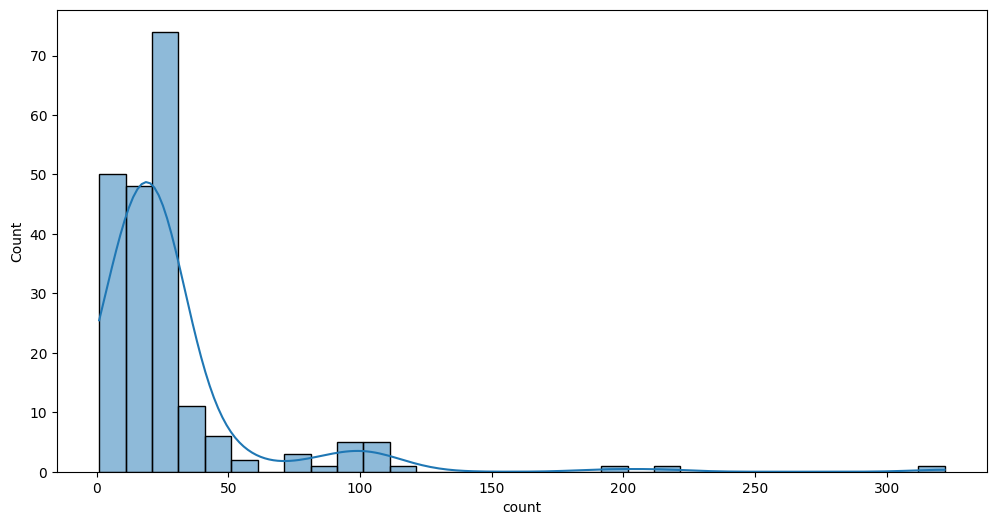

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=sheep_count, x='count', kde=True, binwidth=10, ax=ax)
plt.show()

The majority of the breed have <= 50 samples. Try to focus to the higher column,
for example where counts > 20 and <=30:

In [5]:
selected = sheep_count[(sheep_count['count'] <= 30) & (sheep_count['count'] > 20)]
print(f"There are {selected['count'].shape[0]} breeds having samples between 20 and 30")

There are 84 breeds having samples between 20 and 30


Now extract randomly a certain number of breeds and make a CSV file that I can use
to extract genotypes using `nf-treeseq` pipeline:

In [6]:
np.random.seed(42)
repeats = 5
breed_size = [1, 2, 5, 10, 15, 20]

for i in breed_size:
    for j in range(repeats):
        sample = selected['breed_code'].sample(n=i, replace=False)
        filename = f"{i}_breeds-{j}-50K.csv"
        sample_df = sheep[sheep['breed_code'].isin(sample)]
        sample_df[["breed_code", "smarter_id"]].to_csv(get_data_dir() / filename, index=False, header=False, sep="\t")